In [207]:
%pylab inline
import rlcompleter, readline
readline.parse_and_bind('tab: complete')

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [206]:
train_label = np.genfromtxt('label.txt')
test_label = np.asarray([1]*300+[0]*300)

In [5]:
train_vectors = np.genfromtxt('train_feature_vectors.txt')
test_vectors = np.genfromtxt('test_feature_vectors.txt')

In [233]:
# there are samples in testing set that doesn't contain any words in dictionary
#which means the feature_vectors are empty.
index = [i for i in range(test_vectors.shape[0]) if np.sum(test_vectors[i]) == 0]
clean_test_vectors = np.delete(test_vectors,index,0)
clean_test_label = np.delete(test_label,index,0)
clean_test_vectors.shape,clean_test_label.shape
#after cleaning, 597 testing sample remain

((597, 4361), (597,))

In [264]:
train_dic = np.genfromtxt('train_dic.txt')
test_dic = np.genfromtxt('test_dic.txt')
clean_test_dic = np.delete(test_dic,index,0)
clean_test_dic.shape

(597,)

#Weighting strategy

In [7]:
#I tried to nomalize the term-frequency vectors and apply the data into k-means. The performance is not desirable.
#I found that many fecture vectors have same distances with each cluster centriods.
#I guess that's because using frequency of words can't well differentiate each feacture vectors.
#therefore I apply tf-idf strategy to weighting the words.
#reference resource: http://blog.christianperone.com/2011/10/machine-learning-text-feature-extraction-tf-idf-part-ii/
def tf_idf(train_vectors):
    tf_idf_train = np.zeros_like(train_vectors)
    for i in range(train_vectors.shape[1]):
        tf_idf_train[:,i] = np.log(len(train_vectors)/1+np.count_nonzero(train_vectors[:,i])) * train_vectors[:,i]
    return tf_idf_train

In [235]:
tf_idf_train = tf_idf(train_vectors)
tf_idf_test = tf_idf(clean_test_vectors)

#Normalization After Weighting

In [236]:
#normalize the data
#there are many zero elements in matrix. So if there is words with really high frequencies, that might account to bias.
#to reduce the influence of high frequency words.
def normalization(train):
    train = np.asarray(train)
    s_train = []
    for i in range(train.shape[0]):
        s_train.append(train[i]/np.sqrt(np.sum((train[i])**2)))
    return np.asarray(s_train)

In [237]:
normalize_train = normalization(tf_idf_train)
normalize_test = normalization(tf_idf_test)

In [238]:
[i for i in normalize_train[1] if i != 0]

[0.70994625327525807, 0.704255860792385]

#Clustering

#K-means

In [239]:
# k-means implementation
from scipy.spatial import distance
def k_means(train,threshold):
    #initial centroid
    new_m1 = train[np.random.randint(len(train))]
    new_m2 = train[np.random.randint(len(train))]
    diff = 1000
#keep interation until the different between new centroid and old centriod go under the treshold
    while(diff > threshold):
        c1, c2= [],[]
        c1_label,c2_label = [],[]
        m1,m2 = new_m1,new_m2
        print np.sum(m1),np.sum(m2)
        for i,line in enumerate(train):
#            print np.sum(line)
            dis1 = np.sqrt(sum((line - m1) ** 2))
            dis2 = np.sqrt(sum((line - m2) ** 2))
#            print "dis:",dis1,dis2
            #assign each sample to nearest centroid
            if(dis1 > dis2):
                c2.append(line)
                c2_label.append(label[i]);
            if(dis1 < dis2):
                c1.append(line)
                c1_label.append(label[i]);
            if(dis1 == dis2):
                x = np.random.randint(2);
                if(x == 0):
                    c1.append(line)
                    c1_label.append(label[i]);
                if(x == 1):
                    c2.append(line) 
                    c2_label.append(label[i]);
        #adjust centroid
        new_m1 = np.mean(np.asarray(c1),axis = 0)
        new_m2 = np.mean(np.asarray(c2),axis = 0)
        print "new",np.sum(new_m1),np.sum(new_m2)
        #compute the difference between new centroids and old centroids
        diff = (np.sqrt(sum((new_m1 - m1) ** 2)) + np.sqrt(sum((new_m2 - m2) ** 2)))/2
        print "diff",diff
    return new_m1,new_m2,c1,c2,c1_label,c2_label  

In [355]:
m1,m2,c1,c2,c1_labe1,c2_label = k_means(normalize_train,0.5)
print m1,m2

4.35888869103 2.64574141828
new 2.64922110891 2.2714863034
diff 0.978722185343
2.64922110891 2.2714863034
new 2.88776806493 2.29631920676
diff 0.0897457062813
[ 0.          0.          0.         ...,  0.          0.          0.00141879] [ 0.00016928  0.00023969  0.00027689 ...,  0.00019568  0.00021392
  0.00061465]


In [241]:
def vote(c):
    count0 = len([i for i in c if i == 0.0])
    count1 = len([i for i in c if i == 1.0])
#    print count0,count1
    if(count0 > count1):
        return 0.0
    else:
        return 1.0

In [354]:
vote_c1 = vote(c1_label)
vote_c2 = vote(c2_label)
len(c1)

1860

In [243]:
vote_c1,vote_c2

(1.0, 1.0)

In [244]:
#evaluate performance of k-menas
def evaluation(c1_label,vote_c1,c2_label,vote_c2):
    ratio1 = len([i for i in c1_label if i == vote_c1])/float(len(c1_label))
    ratio2 = len([i for i in c2_label if i == vote_c2])/float(len(c2_label))
    print "cluster 1 score:",ratio1,"cluster2 score:",ratio2
    ratio = (len([i for i in c1_label if i == vote_c1])+len([i for i in c2_label if i == vote_c2]))/float((len(c1_label)+len(c2_label)))
    return ratio


In [245]:
evaluation(c1_labe1,vote_c1,c2_label,vote_c2)

cluster 1 score: 0.494086021505 cluster2 score: 0.52037037037


0.5

#Sentiment prediction

0.788944723618
[[232  65]
 [ 61 239]]


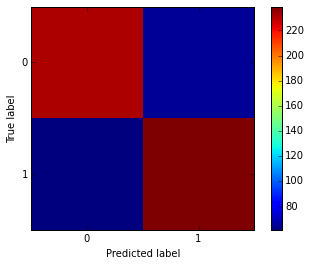

In [282]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(normalize_train,train_label)
#report accuracy of logistic regression
pred = clf.predict(normalize_test)
accuracy = clf.score(normalize_test,clean_test_label)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(clean_test_label,pred)
plt.imshow(cm, interpolation='nearest')
plt.colorbar()
tick_marks = np.array([0,1])
plt.xticks(tick_marks, [0,1])
plt.yticks(tick_marks, [0,1])
plt.ylabel('True label')
plt.xlabel('Predicted label')
print accuracy
print cm

In [352]:
dic = np.genfromtxt('dic.txt',dtype='str')
maxs = sorted(clf.coef_[0])[len(clf.coef_)-21:]
#print max_5
keywords = []
for each in maxs:
    index = [i for i in range(clf.coef_.shape[1]) if clf.coef_[0][i] == each]
    keywords.extend(dic[index])
print keywords

['cool', 'liked', 'interesting', 'comfortable', 'definitely', 'recommend', 'delicious', 'fine', 'fantastic', 'beautiful', 'amazing', 'loved', 'wonderful', 'well', 'good', 'nice', 'best', 'excellent', 'love', 'great']
